<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Question-1" data-toc-modified-id="Question-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 1</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Getting-the-Data" data-toc-modified-id="Getting-the-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Getting the Data</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li></ul></div>

# Question 1

## Imports

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random
import unicodedata
import string
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

## Getting the Data

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -o data.zip

--2019-07-30 11:27:27--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.181.24, 99.84.181.40, 99.84.181.45, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.181.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.09s   

2019-07-30 11:27:27 (31.5 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]




In [5]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
random.shuffle(pairs)
training_data = pairs[0:int(math.floor(0.9*len(pairs)))]
testing_data = pairs[int(math.floor(0.9*len(pairs)))+1:]
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['vous etes toujours vivant .', 'you re still alive .']


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
    
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, attention=True):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

   
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False


    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            if attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)                
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden) 
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def eval(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH, attention=True):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        if attention:
            decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
        else:
            decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden) 
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=2000, plot_every=1000, learning_rate=0.01, attention=True):
    start = time.time()
    plot_losses = []
    plot_test_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(training_data))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, attention=attention)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
        # Compute loss based on test data
        if iter % plot_every == 0:
            test_loss = 0
            for testing_pair in testing_data:
                testing_pair_tensor = tensorsFromPair(testing_pair)
                input_tensor = testing_pair_tensor[0]
                target_tensor = testing_pair_tensor[1]
                test_loss = test_loss + eval(input_tensor, target_tensor, encoder, decoder, criterion, attention=attention)
            plot_test_losses.append(test_loss / len(testing_data))
            
    return plot_test_losses
    
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [13]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

attn_losses = trainIters(encoder1, attn_decoder1, 75000)

1m 4s (- 39m 7s) (2000 2%) 3.2183
2m 15s (- 39m 58s) (4000 5%) 2.7156
3m 26s (- 39m 33s) (6000 8%) 2.5084
4m 37s (- 38m 48s) (8000 10%) 2.3729
5m 49s (- 37m 51s) (10000 13%) 2.2091
7m 1s (- 36m 54s) (12000 16%) 2.0829
8m 13s (- 35m 52s) (14000 18%) 2.0190
9m 25s (- 34m 46s) (16000 21%) 1.8720
10m 37s (- 33m 39s) (18000 24%) 1.7728
11m 49s (- 32m 31s) (20000 26%) 1.6671
13m 2s (- 31m 24s) (22000 29%) 1.5898
14m 14s (- 30m 16s) (24000 32%) 1.5203
15m 27s (- 29m 7s) (26000 34%) 1.4401
16m 39s (- 27m 57s) (28000 37%) 1.4181
17m 51s (- 26m 47s) (30000 40%) 1.3603
19m 4s (- 25m 37s) (32000 42%) 1.2924
20m 16s (- 24m 27s) (34000 45%) 1.2393
21m 28s (- 23m 16s) (36000 48%) 1.1089
22m 41s (- 22m 5s) (38000 50%) 1.0664
23m 54s (- 20m 55s) (40000 53%) 1.0474
25m 7s (- 19m 44s) (42000 56%) 0.9625
26m 19s (- 18m 33s) (44000 58%) 0.9388
27m 32s (- 17m 21s) (46000 61%) 0.9410
28m 46s (- 16m 11s) (48000 64%) 0.9159
29m 59s (- 14m 59s) (50000 66%) 0.8607
31m 12s (- 13m 48s) (52000 69%) 0.8462
32m 25s (

In [14]:
evaluateRandomly(encoder1, attn_decoder1)

> vous etes vilain .
= you are naughty .
< you re bad . <EOS>

> tu es tot a la maison non ?
= you re home early aren t you ?
< you re the one one one one he ? he

> je suis plus vieux que ton frere .
= i m older than your brother .
< i m older than your brother . <EOS>

> ils sont artistes .
= they are artists .
< they are artists . <EOS>

> tu es le seul a me comprendre .
= you re the only one who understands me .
< you re the only one who understands me . <EOS>

> je ne suis pas saoul a ce point .
= i m not all that drunk .
< i m not this for this . <EOS>

> je ne cours pas le moindre danger .
= i m not in any danger .
< i m not in any danger . <EOS>

> je suis grassouillette .
= i m chubby .
< i am a . <EOS>

> je me rends en ville .
= i m going downtown .
< i m going town . <EOS>

> il est fauche .
= he s broke .
< he s broke . <EOS>



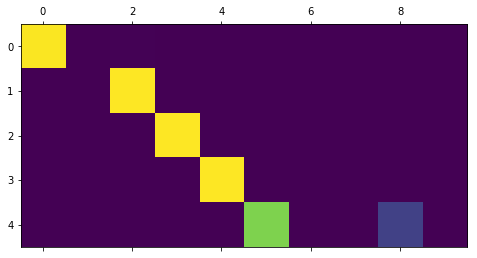

In [15]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


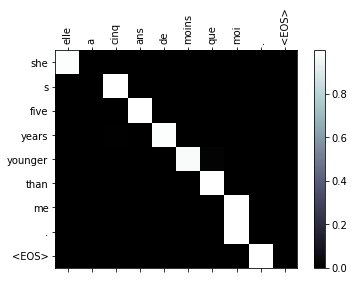

input = elle est trop petit .
output = she s too slow . <EOS>


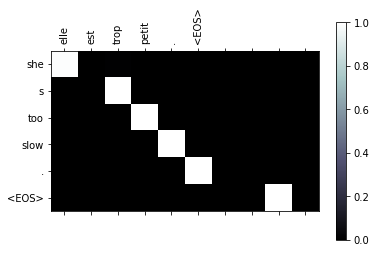

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


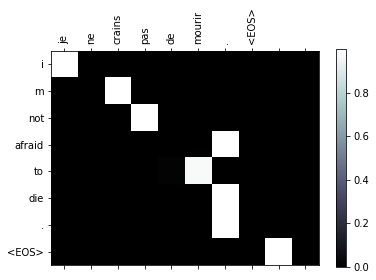

input = c est un jeune directeur plein de talent .
output = he s a talented young young . <EOS>


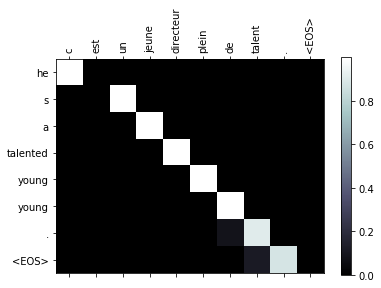

In [16]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

In [17]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attnless_decoder2 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

attnless_losses = trainIters(encoder2,attnless_decoder2 , 75000, attention=False)

0m 46s (- 28m 11s) (2000 2%) 3.2884
1m 34s (- 28m 1s) (4000 5%) 2.7924
2m 25s (- 27m 54s) (6000 8%) 2.6008
3m 15s (- 27m 20s) (8000 10%) 2.4374
4m 6s (- 26m 41s) (10000 13%) 2.3284
4m 57s (- 26m 0s) (12000 16%) 2.1646
5m 48s (- 25m 19s) (14000 18%) 2.0179
6m 39s (- 24m 32s) (16000 21%) 1.9410
7m 30s (- 23m 46s) (18000 24%) 1.8664
8m 22s (- 23m 1s) (20000 26%) 1.8337
9m 13s (- 22m 13s) (22000 29%) 1.6495
10m 5s (- 21m 26s) (24000 32%) 1.5643
10m 56s (- 20m 38s) (26000 34%) 1.4838
11m 48s (- 19m 48s) (28000 37%) 1.4473
12m 39s (- 18m 59s) (30000 40%) 1.3763
13m 31s (- 18m 10s) (32000 42%) 1.2641
14m 22s (- 17m 20s) (34000 45%) 1.2431
15m 13s (- 16m 30s) (36000 48%) 1.2000
16m 5s (- 15m 40s) (38000 50%) 1.1414
16m 57s (- 14m 50s) (40000 53%) 1.0772
17m 48s (- 13m 59s) (42000 56%) 1.0437
18m 40s (- 13m 9s) (44000 58%) 1.0051
19m 31s (- 12m 18s) (46000 61%) 0.9776
20m 23s (- 11m 28s) (48000 64%) 0.8675
21m 14s (- 10m 37s) (50000 66%) 0.8594
22m 6s (- 9m 46s) (52000 69%) 0.8189
22m 57s (- 8m

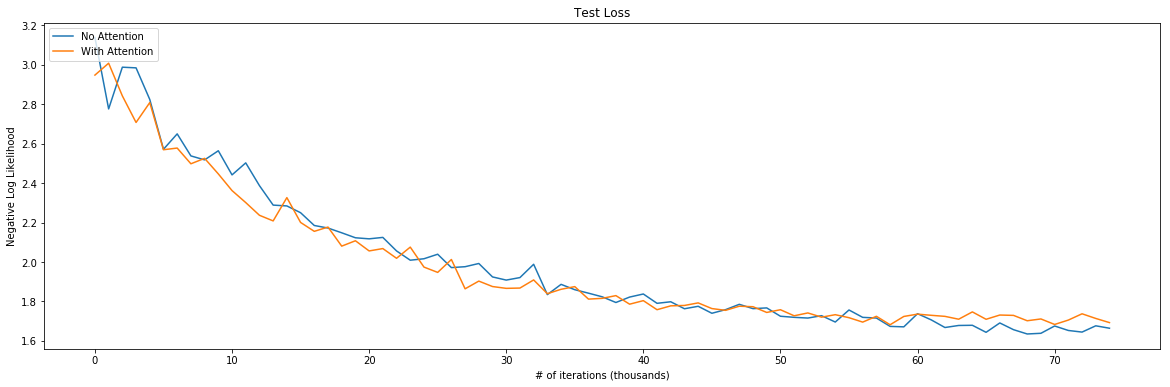

In [20]:
plt.figure(figsize=(20, 6))

plt.plot(attnless_losses)
plt.plot(attn_losses)


plt.xlabel('# of iterations (thousands)')
plt.ylabel('Negative Log Likelihood')
plt.title('Test Loss')

plt.legend(['No Attention', 'With Attention',], loc='upper left')

plt.show()

## Discussion

The attention decoder and the non-attention decoder perform very similarly. This is because the sequence lengths of sentences are short and the information of the sentence is captured well by the fixed-length context vector created by the encoder. We don't really require attention here to create a context vector for each time step. Instead, a single context vector from the encoder suffices in carrying all the embedding information for the sentence.

Attention may work better for longer sequences where the network is unable to capture the entire corpus in the context vector or has trouble aligning itself to the correct part of the sequence.